In [2]:
import numpy as np
import pandas as pd
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib
from utils import *

## Settings and paramters to the script

In [3]:
benchmarks = {"transcode": "cats-1", "pigo-faceblur": "faces2", "pigo-face-detector": "faces2", "openfaas-ocr": "doc", "linpack": "2500", "s3": "cats-1"}
# benchmarks = {"transcode": "cats-1"} 

# sampling_techniques = ["random", "lhs", "model"]
sampling_techniques = ["model"]

CPU_LIMITS= [ '250m', '500m', '750m', '1000m', '1250m', '1500m', '1750m', '2000m' ]
MEMORY_LIMITS=[ '128Mi', '256Mi', '512Mi', '768Mi', '1024Mi', '2048Mi' ]
instance_types = ['m5', 'm5a', 'c5', 'c5a', 'c6g', 'm6g']

benchmark_naming = {"transcode": "transcode", "pigo-faceblur": "faceblur", "pigo-face-detector": "facedetect", "classifier": "classifier", "linpack": "linpack", "s3": "s3", "openfaas-ocr": "ocr"}

N_TRAILS = 20 
N_INIT_SAMPLES = 20
N_OPT_TRAILS = 10

data_dir = 'analysis_data/'

calculate_cpu_mem_costs()

In [80]:
def error_for_best_configs_threshold(model, function_name, threshold, min_result, min_result_om, metric='runtime', metric_om = 'cost'):
    mape = {}

    model_all_predictions = model.get_all_config_predictions(function_name)
    # print(model_top_k)
    minimum, _, _ = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name, metric=metric)

    actual_filtered = []
    filtered = []

    om_actual_filtered = []
    om_filtered = []

    filtered_configs=[]

    for i in range(0, len(model_all_predictions)):
        pred_result = model_all_predictions[i][0]

        conf = model_all_predictions[i][1]
        config = {'instance_type': conf[0], 'cpu': conf[1], 'memory': conf[2]}
        result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric=metric)
        result_om = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric=metric_om)

        # Calculate the value for the secondary metric based on the primary metric
        if metric_om == 'cost':
            r = calculate_cost(conf[1], conf[2], pred_result, conf[0])
        else:
            r = calculate_runtime(conf[1], conf[2], pred_result, conf[0])

        if pred_result <= (1+threshold)*min_result and r < min_result_om:
            filtered.append(result)
            om_filtered.append(r)
            filtered_configs.append(config)

        if result <= (1+threshold)*minimum:
            actual_filtered.append(result)
            om_actual_filtered.append(result_om)

    index_actual = om_actual_filtered.index(min(om_actual_filtered))
    
    if len(filtered) == 0:
        # actual_min_pred = 0.0
        # min_filtered = 0.0
        mape[metric_om] = 0.0
        mape[metric] = 0.0

        return mape, {metric: 1.0 , metric_om: 1.0}, {metric: 1.0 , metric_om: 1.0}
    else:
        index = om_filtered.index(min(om_filtered))
        om_actual_min_pred = get_result_from_data(function_name, data_name, filtered_configs[index], MEMORY_LIMITS, metric=metric_om)
        min_filtered = filtered[index]

        mape[metric_om] = 100*abs(om_actual_min_pred-min(om_actual_filtered))/min(om_actual_filtered)
        mape[metric] = 100*abs(min_filtered-actual_filtered[index_actual])/actual_filtered[index_actual]
    # mae = 0.0
    # for i in range(0, len(model_all_predictions)):
    #     e = abs(model_all_predictions[i][0]-actual_performance[i][0])/actual_performance[i][0]
    #     # if e*100 > 50.0:
    #     #     print(actual_performance[i][0], model_all_predictions[i])
    #     mae += e
    
    # mae = 100*mae/float(len(model_all_predictions))

    # print(mape)
        print(filtered_configs[index])
        print(om_actual_min_pred, min_result_om)
        return mape, {metric: min_filtered/min_result , metric_om: om_actual_min_pred/min_result_om}, {metric : actual_filtered[index_actual]/min_result, metric_om: min(om_actual_filtered)/min_result_om}

## Run Hierarchical Optimization
Performance hierarchical optimization and generate the results.

**Note: This would be a long running process (in the order of minutes)**

In [ ]:
errors = pd.DataFrame(columns=['benchmark', 'trials', 'mape', 'estimator'])
gains = pd.DataFrame()
ideals = pd.DataFrame()

metrics=['runtime', 'cost']

for metric in metrics:
    metric_om = 'runtime' if metric == 'cost' else 'cost'

    for function_name in benchmarks.keys():
        runtimes = pd.DataFrame(columns=['trials', 'runtime', 'cost', 'metric value', 'sampling', 'metric', 'config'])
        data_name = benchmarks[function_name]
        print(function_name)
        for x in range(0, N_OPT_TRAILS):
            base_estimator = "GP"
            min_value = {}
            observed_min_metric = 600.0
            observed_min_om = 600.0 
            

            for sampling_technique in sampling_techniques:
                # print(sampling_technique)
                observed_min_metric = 600.0
                observed_min_om = 600.0 

                if sampling_technique == "random":
                    N_INIT_SAMPLES = 20
                    init_samples = get_random_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES)
                elif sampling_technique == "lhs":
                    N_INIT_SAMPLES = 20
                    init_samples = get_lhs_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES)
                elif sampling_technique == "model":
                    N_INIT_SAMPLES = 3
                    init_samples = get_lhs_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x, n_samples=N_INIT_SAMPLES)

                default_config = init_samples[0]
                config = default_config

                from optimizer.boskopt import Models
                model = Models()
                model.create_model(function=function_name, base_estimator=base_estimator, seed=x)


                for i in range(0, N_TRAILS):
                    success = True
                    result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric=metric)
                    # print(result) 

                    if result < observed_min_metric:
                        observed_min_metric = result
                        
                        if metric_om == 'cost':
                            observed_min_om = calculate_cost(config["cpu"], config["memory"], result, config["instance_type"])
                        else:
                            observed_min_om = calculate_runtime(config["cpu"], config["memory"], result, config["instance_type"])

                    model.update(config, result, function_name, success=True)
                    
                    if i < N_INIT_SAMPLES-1:
                        
                        config = init_samples[i+1]
                    else:
                        config = model.get_next_config(function_name)

                
                mape, new_min, ideal_values = error_for_best_configs_threshold(model, function_name, threshold=0.2, min_result = observed_min_metric, min_result_om = observed_min_om, metric=metric, metric_om = metric_om)
                errors = errors.append({'benchmark': function_name, 'trials': x, 'metric': 'runtime', 'mape': mape['runtime'], 'sampling': sampling_technique, 'secondary metric':metric_om}, ignore_index=True)
                errors = errors.append({'benchmark': function_name, 'trials': x, 'metric': 'cost', 'mape': mape['cost'], 'sampling': sampling_technique, 'secondary metric':metric_om}, ignore_index=True)

                # print(new_min[metric], observed_min_metric)
                # print(new_min[metric_om], observed_min_om)

                gains = gains.append({'benchmark': function_name, 'trials': x, 'metric': metric, 'value': new_min[metric], 'sampling': sampling_technique, 'secondary metric':metric_om}, ignore_index=True)
                gains = gains.append({'benchmark': function_name, 'trials': x, 'metric': metric_om, 'value': new_min[metric_om], 'sampling': sampling_technique, 'secondary metric':metric_om}, ignore_index=True)

                gains = gains.append({'benchmark': function_name, 'trials': x, 'metric': 'ideal-' + metric, 'value': ideal_values[metric], 'sampling': sampling_technique, 'secondary metric':metric_om}, ignore_index=True)
                gains = gains.append({'benchmark': function_name, 'trials': x, 'metric': 'ideal-' + metric_om, 'value': ideal_values[metric_om], 'sampling': sampling_technique, 'secondary metric':metric_om}, ignore_index=True)

                # ideals = ideals.append({'benchmark': function_name, 'trials': x, 'metric': metric, 'value': ideal_values[metric], 'sampling': sampling_technique, 'secondary metric':metric_om}, ignore_index=True)
                # ideals = ideals.append({'benchmark': function_name, 'trials': x, 'metric': metric_om, 'value': ideal_values[metric_om], 'sampling': sampling_technique, 'secondary metric':metric_om}, ignore_index=True)

# ideals.to_csv(data_dir + 'ideals-hierarc.csv', index=False)
gains.to_csv(data_dir + 'gains-hierarc.csv', index=False)
errors.to_csv(data_dir + 'error-hierarc.csv', index=False)

### This plot isn't used. Please ignore

No handles with labels found to put in legend.


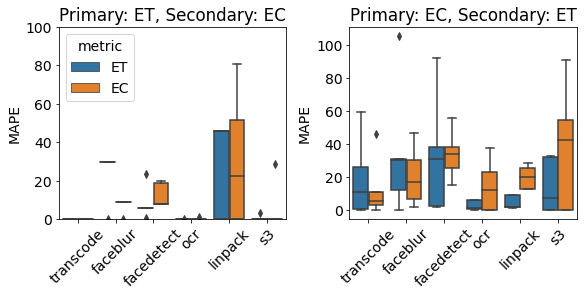

In [44]:
matplotlib.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(figsize=(8, 4), ncols=2, constrained_layout=True)

errors = pd.read_csv(data_dir + 'error-hierarc.csv')
errors = errors[errors['secondary metric']=='cost']
errors.replace(benchmark_naming, inplace=True)
errors.replace({'runtime': 'ET', 'cost': 'EC'}, inplace=True)
ax = sns.boxplot(data=errors, y='mape', x='benchmark', hue='metric', ax=axs[0])
ax.set_title('Primary: ET, Secondary: EC')
ax.set_ylabel('MAPE')
ax.set_ylim(0, 100)
ax.xaxis.label.set_visible(False)
ax.tick_params(axis='x', rotation=45)
# ax.legend().set_visible(False)
plt.legend()


errors = pd.read_csv(data_dir + 'error-hierarc.csv')
errors = errors[errors['secondary metric']=='runtime']
errors.replace(benchmark_naming, inplace=True)
ax = sns.boxplot(data=errors, y='mape', x='benchmark', hue='metric', ax=axs[1])
ax.set_title('Primary: EC, Secondary: ET')
ax.tick_params(axis='x', rotation=45)
ax.legend().set_visible(False)
ax.set_ylabel('MAPE')
ax.xaxis.label.set_visible(False)
# plt.show()
plt.savefig('hierarc-mo.pdf', bbox_inches = "tight")

### Plot results for Hierarchical Optimization

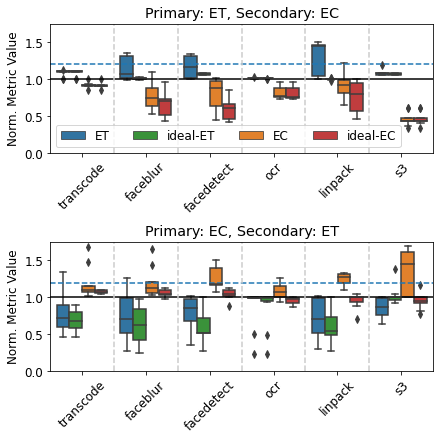

In [5]:
matplotlib.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(figsize=(6, 6), ncols=1, nrows=2, constrained_layout=True)

palette ={"ET": "C0", "EC": "C1", "ideal-ET": "C2", "ideal-EC": "C3"}

gains = pd.read_csv(data_dir + 'gains-hierarc.csv')
gains = gains[gains['secondary metric']=='cost']
gains.replace(benchmark_naming, inplace=True)
gains.replace({'runtime': 'ET', 'cost': 'EC', 'ideal-cost': 'ideal-EC', 'ideal-runtime': 'ideal-ET'}, inplace=True)
# print(gains)
hue_order = ['ET','ideal-ET', 'EC', 'ideal-EC']

ax = sns.boxplot(data=gains, y='value', x='benchmark', hue='metric', ax=axs[0], hue_order=hue_order, palette=palette)

# ideals = pd.read_csv(data_dir + 'ideals-hierarc.csv')
# ideals = ideals[ideals['secondary metric']=='cost']
# ideals.replace(benchmark_naming, inplace=True)
# ideals.replace({'runtime': 'ET', 'cost': 'EC'}, inplace=True)
# ax = sns.boxplot(data=ideals, y='value', x='benchmark', hue='metric', ax=axs[0])
ax.axhline(1.2, ls='--')
ax.axhline(1.0, ls='-', color='black')
ax.set_title('Primary: ET, Secondary: EC')
ax.set_ylabel('Norm. Metric Value')
ax.set_ylim(0, 1.75)
ax.xaxis.label.set_visible(False)
ax.tick_params(axis='x', rotation=45)
ax.legend(ncol=4)
[ax.axvline(x, color = '0.8', linestyle='--') for x in [0.5,1.5,2.5,3.5, 4.5]]


gains = pd.read_csv(data_dir + 'gains-hierarc.csv')
hue_order = ['ET','ideal-ET', 'EC', 'ideal-EC']
gains = gains[gains['secondary metric']=='runtime']
gains.replace(benchmark_naming, inplace=True)
gains.replace({'runtime': 'ET', 'cost': 'EC', 'ideal-cost': 'ideal-EC', 'ideal-runtime': 'ideal-ET'}, inplace=True)
ax = sns.boxplot(data=gains, y='value', x='benchmark', hue='metric', ax=axs[1], hue_order=hue_order, palette=palette)
ax.set_title('Primary: EC, Secondary: ET')
ax.tick_params(axis='x', rotation=45)
ax.axhline(1.2, ls='--')
ax.axhline(1.0, ls='-', color='black')
ax.set_ylim(0, 1.75)
ax.legend().set_visible(False)
ax.set_ylabel('Norm. Metric Value')
ax.xaxis.label.set_visible(False)
# plt.show()

# Legends outside the figure
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0))
[ax.axvline(x, color = '0.8', linestyle='--') for x in [0.5,1.5,2.5,3.5, 4.5]]

plt.savefig('hierarc-mo.pdf', bbox_inches = "tight")